In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

df = pd.read_parquet('../data/songs_optimized.parquet')

In [2]:
df.head()

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,29th April 2013,D min,105,...,False,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,29th April 2013,A# min,117,...,False,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,8th June 2004,A Maj,121,...,False,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,16th October 2015,A min,122,...,False,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,16th October 2015,F min,123,...,False,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415


In [3]:
df.dtypes

Artist(s)                         category
song                                object
text                                object
Length                              object
emotion                           category
Genre                             category
Album                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                              bool
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                        bool
Good for Work/Study                   bool
Good for Re

In [4]:
#guardar nombre de las canciones, para la validación?
nameSongs = df['song']

In [5]:
#columnas a eliminar que no tienen relevancia para predecir la popularidad
columnas_innecesarias = ['Artist(s)', 'text', 'Similar Artist 1', 'Similar Song 1', 'Similar Artist 2', 'Similar Song 2',
                         'Similar Artist 3', 'Similar Song 3', 'Similarity Score 1', 'Similarity Score 2', 'Similarity Score 3',
                         'song', 'Album']

#eliminar release date??

In [6]:
#eliminar columnas
df.drop(columns = columnas_innecesarias, inplace = True)

In [7]:
df.dtypes

Length                              object
emotion                           category
Genre                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                              bool
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                        bool
Good for Work/Study                   bool
Good for Relaxation/Meditation        bool
Good for Exercise                     bool
Good for Running                      bool
Good for Yoga/Stretching              bool
Good for Dr

In [8]:
#ver si faltan datos
df.isnull().sum()

Length                            0
emotion                           0
Genre                             0
Release Date                      0
Key                               0
Tempo                             0
Loudness (db)                     0
Time signature                    8
Explicit                          0
Popularity                        0
Energy                            0
Danceability                      0
Positiveness                      0
Speechiness                       0
Liveness                          0
Acousticness                      0
Instrumentalness                  0
Good for Party                    0
Good for Work/Study               0
Good for Relaxation/Meditation    0
Good for Exercise                 0
Good for Running                  0
Good for Yoga/Stretching          0
Good for Driving                  0
Good for Social Gatherings        0
Good for Morning Routine          0
dtype: int64

In [9]:
#en las siguientes líneas de código se van a formatear
#todas las columnas para que tengan entradas numéricas

In [10]:
#convertir duración de la canción a segundos
df['Duration_sec'] = df['Length'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))
df.drop(columns=['Length'], inplace=True)  # eliminar la columna original

In [11]:
#convertir Loudness a valor numérico (quitar db y que no sea object)
df['Loudness (db)'] = df['Loudness (db)'].str.replace('db', '', regex=False).str.strip()
df['Loudness (db)'] = pd.to_numeric(df['Loudness (db)'], errors='coerce')

In [12]:
#confirmar si se hizo bien la conversión
print(f"Valores NaN en Loudness (db): {df['Loudness (db)'].isna().sum()}")

Valores NaN en Loudness (db): 0


In [13]:
print(df['Loudness (db)'].head())


0   -6.85
1   -5.75
2   -6.06
3   -5.42
4   -5.57
Name: Loudness (db), dtype: float64


In [14]:
#convertir columnas booleanas a valor 0 y 1
#identificar las columnas
bool_cols = df.select_dtypes(include='bool').columns
#hacer conversión
df[bool_cols] = df[bool_cols].astype(int)

In [15]:
#ver datos
print(df[bool_cols].head())

   Explicit  Good for Party  Good for Work/Study  \
0         0               0                    0   
1         0               0                    0   
2         0               0                    0   
3         0               0                    0   
4         0               0                    0   

   Good for Relaxation/Meditation  Good for Exercise  Good for Running  \
0                               0                  0                 0   
1                               0                  0                 0   
2                               0                  1                 0   
3                               0                  1                 0   
4                               0                  1                 0   

   Good for Yoga/Stretching  Good for Driving  Good for Social Gatherings  \
0                         0                 0                           0   
1                         0                 0                           0   
2          

In [16]:
df.dtypes

emotion                           category
Genre                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                      float64
Time signature                    category
Explicit                             int64
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                       int64
Good for Work/Study                  int64
Good for Relaxation/Meditation       int64
Good for Exercise                    int64
Good for Running                     int64
Good for Yoga/Stretching             int64
Good for Driving                     int64
Good for So

In [17]:
#ver cantidad de valores distintos
df['emotion'].nunique()
df['Genre'].nunique()

3097

In [18]:
#hacer one hot encodig para las columnas de tipo category
from sklearn.preprocessing import OneHotEncoder
colTypeCategory = ['emotion', 'Key', 'Time signature']
encoder = OneHotEncoder(sparse_output = False) #retorne un array denso
encoded = encoder.fit_transform(df[colTypeCategory]) #aplicar encoder a las columnas

#convertir el array a un dataframe
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(colTypeCategory))
#eliminar columnas de tipo category
df = df.drop(colTypeCategory, axis=1)
#añadir columnas de encoded_df al df original
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)


In [19]:
df.dtypes

Genre                 category
Release Date            object
Tempo                    int64
Loudness (db)          float64
Explicit                 int64
                        ...   
Time signature_1/4     float64
Time signature_3/4     float64
Time signature_4/4     float64
Time signature_5/4     float64
Time signature_nan     float64
Length: 65, dtype: object

In [20]:
timeSignature_cols = [col for col in df.columns if col.startswith('Time signature')]
print(timeSignature_cols)

['Time signature_1/4', 'Time signature_3/4', 'Time signature_4/4', 'Time signature_5/4', 'Time signature_nan']


In [21]:
key_cols = [col for col in df.columns if col.startswith('Key_')]
print("Categorías de key codificadas:", key_cols)

Categorías de key codificadas: ['Key_A Maj', 'Key_A min', 'Key_A# Maj', 'Key_A# min', 'Key_B Maj', 'Key_B min', 'Key_C Maj', 'Key_C min', 'Key_C# Maj', 'Key_C# min', 'Key_D Maj', 'Key_D min', 'Key_D# Maj', 'Key_D# min', 'Key_E Maj', 'Key_E min', 'Key_F Maj', 'Key_F min', 'Key_F# Maj', 'Key_F# min', 'Key_G Maj', 'Key_G min', 'Key_G# Maj', 'Key_G# min']


In [22]:
emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
print("Categorías de emotion codificadas:", emotion_cols)

Categorías de emotion codificadas: ['emotion_Love', 'emotion_True', 'emotion_anger', 'emotion_angry', 'emotion_confusion', 'emotion_fear', 'emotion_interest', 'emotion_joy', 'emotion_love', 'emotion_pink', 'emotion_sadness', 'emotion_surprise', 'emotion_thirst']


In [23]:
#con genre no era conveniente hace One Hot coding, porque creaba una columna por cada
#combinación de géneros que tenía una canción, y se quiere una columna por cada género único
from sklearn.preprocessing import MultiLabelBinarizer #para hacer la conversión

#crear lista con los géneros presentes en el dataset
df['listaGeneros'] = df['Genre'].str.split(',')
#apra usar el codificador
mlb = MultiLabelBinarizer()
#asignación de 0 y 1 por cada lista de géneros en Genre por canción
listaGenreBinario = pd.DataFrame(mlb.fit_transform(df['listaGeneros']),
                             columns=[f'Genre_{g.strip()}' for g in mlb.classes_],
                             index=df.index)
#agregar las columnnas por cada género al df
df = pd.concat([df, listaGenreBinario], axis=1)

#sacar las columnas que no se necesitan
df.drop(columns=['Genre', 'listaGeneros'], inplace=True)

In [24]:
df.dtypes

Release Date           object
Tempo                   int64
Loudness (db)         float64
Explicit                int64
Popularity              uint8
                       ...   
Genre_thrash metal      int64
Genre_trance            int64
Genre_trap              int64
Genre_trip-hop          int64
Genre_worship           int64
Length: 152, dtype: object

In [25]:
genre_cols = [col for col in df.columns if col.startswith('Genre_')]
print(genre_cols)

['Genre_acoustic', 'Genre_alt-country', 'Genre_alternative', 'Genre_alternative rock', 'Genre_ambient', 'Genre_black metal', 'Genre_blues', 'Genre_britpop', 'Genre_chillout', 'Genre_chillwave', 'Genre_christian', 'Genre_classic rock', 'Genre_classical', 'Genre_cloud rap', 'Genre_comedy', 'Genre_country', 'Genre_dance', 'Genre_dancehall', 'Genre_death metal', 'Genre_deathcore', 'Genre_disco', 'Genre_doom metal', 'Genre_dream pop', 'Genre_drum and bass', 'Genre_dub', 'Genre_dubstep', 'Genre_electro', 'Genre_electronic', 'Genre_electropop', 'Genre_emo', 'Genre_emo rap', 'Genre_experimental', 'Genre_folk', 'Genre_funk', 'Genre_garage rock', 'Genre_gospel', 'Genre_grime', 'Genre_grunge', 'Genre_hard rock', 'Genre_hardcore', 'Genre_heavy metal', 'Genre_hip hop', 'Genre_hip-hop', 'Genre_house', 'Genre_indie', 'Genre_indie pop', 'Genre_indie rock', 'Genre_industrial', 'Genre_j-pop', 'Genre_jazz', 'Genre_k-pop', 'Genre_latin', 'Genre_lo-fi', 'Genre_math rock', 'Genre_melodic death metal', 'Genr

In [26]:
print(df.columns.tolist())
print(df.info())

['Release Date', 'Tempo', 'Loudness (db)', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine', 'Duration_sec', 'emotion_Love', 'emotion_True', 'emotion_anger', 'emotion_angry', 'emotion_confusion', 'emotion_fear', 'emotion_interest', 'emotion_joy', 'emotion_love', 'emotion_pink', 'emotion_sadness', 'emotion_surprise', 'emotion_thirst', 'Key_A Maj', 'Key_A min', 'Key_A# Maj', 'Key_A# min', 'Key_B Maj', 'Key_B min', 'Key_C Maj', 'Key_C min', 'Key_C# Maj', 'Key_C# min', 'Key_D Maj', 'Key_D min', 'Key_D# Maj', 'Key_D# min', 'Key_E Maj', 'Key_E min', 'Key_F Maj', 'Key_F min', 'Key_F# Maj', 'Key_F# min', 'Key_G Maj', 'Key_G min', 'Key_G# Maj', 'Key_G# min', 'Time signature_1/4', 'Time signature_3

In [27]:
df.drop(columns=['Release Date'], inplace=True)


In [28]:
df

,Tempo,Loudness (db),Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,...,Genre_soul,Genre_soundtrack,Genre_swing,Genre_synthpop,Genre_techno,Genre_thrash metal,Genre_trance,Genre_trap,Genre_trip-hop,Genre_worship
0,105,-6.85,0,40,83,71,87,4,16,11,...,0,0,0,0,0,0,0,0,0,0
1,117,-5.75,0,42,85,70,87,4,32,0,...,0,0,0,0,0,0,0,0,0,0
2,121,-6.06,0,29,89,71,63,8,64,0,...,0,0,0,0,0,0,0,0,0,0
3,122,-5.42,0,24,84,78,97,4,12,12,...,0,0,0,0,0,0,0,0,0,0
4,123,-5.57,0,30,71,77,70,7,10,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551438,140,-10.00,1,31,82,83,19,16,9,39,...,0,0,0,0,0,0,0,0,0,0
551439,128,-9.68,0,29,43,39,26,3,10,54,...,0,0,0,0,0,0,0,0,0,0
551440,75,-4.67,0,21,79,56,41,5,19,0,...,0,0,0,0,0,0,0,0,0,0
551441,126,-3.93,0,5,90,59,69,4,7,27,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#Modelo de red neuronal
class MLP(nn.Module):
    def __init__(self, hidden_size=10, input_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)

        self.act = nn.Sigmoid()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l2 = self.act(l2)     #activación
        output = self.out(l2)   #salida
        return output

In [30]:
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=False)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, shuffle=False)


In [31]:
val_df.shape, test_df.shape, train_df.shape

((82716, 151), (82717, 151), (386010, 151))

In [40]:
#Instanciar el modelo
model = MLP(hidden_size=10, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Convertir el DataFrame a tensores de PyTorch
X_train = torch.tensor(train_df.drop(columns=['Popularity']).values, dtype=torch.float32)  
X_train = DataLoader(X_train, batch_size=8578, shuffle=False)  # Crear DataLoader para el conjunto de entrenamiento
y_train = torch.tensor(train_df['Popularity'].values, dtype=torch.float32).view(-1, 1)  # Asegurarse de que y tenga la forma correcta
y_train = DataLoader(y_train, batch_size=8578, shuffle=False)  # Crear DataLoader para las etiquetas de entrenamiento

X_val = torch.tensor(val_df.drop(columns=['Popularity']).values, dtype=torch.float32)
X_val = DataLoader(X_val, batch_size=3938, shuffle=False)  # Crear DataLoader para el conjunto de validación
y_val = torch.tensor(val_df['Popularity'].values, dtype=torch.float32).view(-1, 1)
y_val = DataLoader(y_val, batch_size=3938, shuffle=False)  # Crear DataLoader para las etiquetas de validación


X_test = torch.tensor(test_df.drop(columns=['Popularity']).values, dtype=torch.float32)
X_test = DataLoader(X_test, batch_size=3939, shuffle=False)  # Crear DataLoader para el conjunto de prueba
y_test = torch.tensor(test_df['Popularity'].values, dtype=torch.float32).view(-1, 1)
y_test = DataLoader(y_test, batch_size=3939, shuffle=False)  # Crear DataLoader para las etiquetas de prueba

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [43]:
len(X_train), len(X_val), len(X_test)

(45, 22, 21)

In [ ]:
#Loop de entrenamiento
epochs = 500  # Número de épocas para el entrenamiento
epoch = 0

batch_size = 8.578
batchs_per_epoch = 45

train_losses = []
val_losses = []

while epoch < epochs:    
    model.train()
    running_loss = 0.0
    for _ in tqdm(range(batchs_per_epoch), desc=f"Epoch {epoch+1}"):
        input, labels = next(iter(X_train)), next(iter(y_train))  # Obtener un batch de datos
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # 🔧 Salidas 
        output= model(input)

        # 🔧 Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / batchs_per_epoch)

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for _ in range(len(X_val)):
            input, labels = next(iter(X_train)), next(iter(y_train))
            input, labels = input.to(device), labels.to(device)

            # 🔧 Solo predicción principal en validación
            outputs = model(input)  # return_aux=False por defecto
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy()

    val_losses.append(val_loss / len(y_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    epoch += 1

Epoch 1: 100%|██████████| 45/45 [00:01<00:00, 23.16it/s]


Época 1 | Train Loss: 858.1194 | Val Loss: 852.6197


Epoch 2: 100%|██████████| 45/45 [00:01<00:00, 23.09it/s]


Época 2 | Train Loss: 847.4148 | Val Loss: 842.0022


Epoch 3: 100%|██████████| 45/45 [00:02<00:00, 19.72it/s]


Época 3 | Train Loss: 836.8801 | Val Loss: 831.5536


Epoch 4: 100%|██████████| 45/45 [00:01<00:00, 22.75it/s]


Época 4 | Train Loss: 826.5125 | Val Loss: 821.2705


Epoch 5: 100%|██████████| 45/45 [00:02<00:00, 21.81it/s]


Época 5 | Train Loss: 816.3114 | Val Loss: 811.1550


Epoch 6: 100%|██████████| 45/45 [00:02<00:00, 20.86it/s]


Época 6 | Train Loss: 806.2752 | Val Loss: 801.2015


Epoch 7: 100%|██████████| 45/45 [00:02<00:00, 20.88it/s]


Época 7 | Train Loss: 796.4031 | Val Loss: 791.4152


Epoch 8: 100%|██████████| 45/45 [00:02<00:00, 21.27it/s]


Época 8 | Train Loss: 786.6980 | Val Loss: 781.7943


Epoch 9: 100%|██████████| 45/45 [00:02<00:00, 20.31it/s]


Época 9 | Train Loss: 777.1569 | Val Loss: 772.3362


Epoch 10: 100%|██████████| 45/45 [00:02<00:00, 21.16it/s]


Época 10 | Train Loss: 767.7778 | Val Loss: 763.0393


Epoch 11: 100%|██████████| 45/45 [00:02<00:00, 18.96it/s]


Época 11 | Train Loss: 758.5587 | Val Loss: 753.9013


Epoch 12: 100%|██████████| 45/45 [00:02<00:00, 22.46it/s]


Época 12 | Train Loss: 749.4967 | Val Loss: 744.9161


Epoch 13: 100%|██████████| 45/45 [00:02<00:00, 20.85it/s]


Época 13 | Train Loss: 740.5718 | Val Loss: 736.0451


Epoch 14: 100%|██████████| 45/45 [00:01<00:00, 22.91it/s]


Época 14 | Train Loss: 731.7775 | Val Loss: 727.3469


Epoch 15: 100%|██████████| 45/45 [00:01<00:00, 22.60it/s]


Época 15 | Train Loss: 723.1599 | Val Loss: 718.8079


Epoch 16: 100%|██████████| 45/45 [00:02<00:00, 21.91it/s]


Época 16 | Train Loss: 714.6937 | Val Loss: 710.4184


Epoch 17: 100%|██████████| 45/45 [00:02<00:00, 20.75it/s]


Época 17 | Train Loss: 706.3790 | Val Loss: 702.1821


Epoch 18: 100%|██████████| 45/45 [00:01<00:00, 25.13it/s]


Época 18 | Train Loss: 698.2204 | Val Loss: 694.1055


Epoch 19: 100%|██████████| 45/45 [00:01<00:00, 23.47it/s]


Época 19 | Train Loss: 690.2191 | Val Loss: 686.1816


Epoch 20: 100%|██████████| 45/45 [00:02<00:00, 22.33it/s]


Época 20 | Train Loss: 682.3683 | Val Loss: 678.4069


Epoch 21: 100%|██████████| 45/45 [00:02<00:00, 22.17it/s]


Época 21 | Train Loss: 674.6653 | Val Loss: 670.7786


Epoch 22: 100%|██████████| 45/45 [00:02<00:00, 19.49it/s]


Época 22 | Train Loss: 667.1079 | Val Loss: 663.2947


Epoch 23: 100%|██████████| 45/45 [00:01<00:00, 24.04it/s]


Época 23 | Train Loss: 659.6938 | Val Loss: 655.9528


Epoch 24: 100%|██████████| 45/45 [00:02<00:00, 21.58it/s]


Época 24 | Train Loss: 652.4087 | Val Loss: 648.7066


Epoch 25: 100%|██████████| 45/45 [00:02<00:00, 21.49it/s]


Época 25 | Train Loss: 645.0955 | Val Loss: 641.2693


Epoch 26: 100%|██████████| 45/45 [00:01<00:00, 25.59it/s]


Época 26 | Train Loss: 637.5588 | Val Loss: 633.7736


Epoch 27: 100%|██████████| 45/45 [00:02<00:00, 21.00it/s]


Época 27 | Train Loss: 630.3022 | Val Loss: 626.7131


Epoch 28: 100%|██████████| 45/45 [00:02<00:00, 19.60it/s]


Época 28 | Train Loss: 623.3342 | Val Loss: 619.8210


Epoch 29: 100%|██████████| 45/45 [00:01<00:00, 24.65it/s]


Época 29 | Train Loss: 616.4940 | Val Loss: 613.0369


Epoch 30: 100%|██████████| 45/45 [00:01<00:00, 23.57it/s]


Época 30 | Train Loss: 609.7810 | Val Loss: 606.3976


Epoch 31: 100%|██████████| 45/45 [00:01<00:00, 22.65it/s]


Época 31 | Train Loss: 603.1965 | Val Loss: 599.8649


Epoch 32: 100%|██████████| 45/45 [00:02<00:00, 21.64it/s]


Época 32 | Train Loss: 596.7071 | Val Loss: 593.4225


Epoch 33: 100%|██████████| 45/45 [00:02<00:00, 20.28it/s]


Época 33 | Train Loss: 590.3305 | Val Loss: 587.1166


Epoch 34: 100%|██████████| 45/45 [00:01<00:00, 23.14it/s]


Época 34 | Train Loss: 584.0585 | Val Loss: 580.8768


Epoch 35: 100%|██████████| 45/45 [00:01<00:00, 22.76it/s]


Época 35 | Train Loss: 577.9018 | Val Loss: 574.8226


Epoch 36: 100%|██████████| 45/45 [00:02<00:00, 21.22it/s]


Época 36 | Train Loss: 571.9206 | Val Loss: 568.8983


Epoch 37: 100%|██████████| 45/45 [00:01<00:00, 22.76it/s]


Época 37 | Train Loss: 566.0214 | Val Loss: 563.0443


Epoch 38: 100%|██████████| 45/45 [00:02<00:00, 20.69it/s]


Época 38 | Train Loss: 560.2461 | Val Loss: 557.3292


Epoch 39: 100%|██████████| 45/45 [00:02<00:00, 20.01it/s]


Época 39 | Train Loss: 554.6029 | Val Loss: 551.7817


Epoch 40: 100%|██████████| 45/45 [00:01<00:00, 24.31it/s]


Época 40 | Train Loss: 549.1235 | Val Loss: 546.3622


Epoch 41: 100%|██████████| 45/45 [00:02<00:00, 21.82it/s]


Época 41 | Train Loss: 543.7712 | Val Loss: 541.0875


Epoch 42: 100%|██████████| 45/45 [00:02<00:00, 20.83it/s]


Época 42 | Train Loss: 538.5627 | Val Loss: 535.9432


Epoch 43: 100%|██████████| 45/45 [00:02<00:00, 20.65it/s]


Época 43 | Train Loss: 533.4817 | Val Loss: 530.9026


Epoch 44: 100%|██████████| 45/45 [00:02<00:00, 20.85it/s]


Época 44 | Train Loss: 528.4508 | Val Loss: 525.8849


Epoch 45: 100%|██████████| 45/45 [00:02<00:00, 20.90it/s]


Época 45 | Train Loss: 523.3629 | Val Loss: 520.7842


Epoch 46: 100%|██████████| 45/45 [00:02<00:00, 22.33it/s]


Época 46 | Train Loss: 518.3977 | Val Loss: 515.9338


Epoch 47: 100%|██████████| 45/45 [00:02<00:00, 20.80it/s]


Época 47 | Train Loss: 513.6201 | Val Loss: 511.2235


Epoch 48: 100%|██████████| 45/45 [00:01<00:00, 24.04it/s]


Época 48 | Train Loss: 508.9733 | Val Loss: 506.6348


Epoch 49: 100%|██████████| 45/45 [00:01<00:00, 22.70it/s]


Época 49 | Train Loss: 504.4383 | Val Loss: 502.1581


Epoch 50: 100%|██████████| 45/45 [00:02<00:00, 21.40it/s]


Época 50 | Train Loss: 500.0155 | Val Loss: 497.7849


Epoch 51: 100%|██████████| 45/45 [00:01<00:00, 26.12it/s]


Época 51 | Train Loss: 495.6475 | Val Loss: 493.4038


Epoch 52: 100%|██████████| 45/45 [00:02<00:00, 22.27it/s]


Época 52 | Train Loss: 491.1523 | Val Loss: 488.3774


Epoch 53: 100%|██████████| 45/45 [00:02<00:00, 20.55it/s]


Época 53 | Train Loss: 485.9492 | Val Loss: 483.5860


Epoch 54: 100%|██████████| 45/45 [00:01<00:00, 23.11it/s]


Época 54 | Train Loss: 481.4333 | Val Loss: 479.1790


Epoch 55: 100%|██████████| 45/45 [00:01<00:00, 22.96it/s]


Época 55 | Train Loss: 477.0822 | Val Loss: 474.8943


Epoch 56: 100%|██████████| 45/45 [00:01<00:00, 23.19it/s]


Época 56 | Train Loss: 472.8540 | Val Loss: 470.7161


Epoch 57: 100%|██████████| 45/45 [00:01<00:00, 24.77it/s]


Época 57 | Train Loss: 468.6752 | Val Loss: 466.5194


Epoch 58: 100%|██████████| 45/45 [00:02<00:00, 22.19it/s]


Época 58 | Train Loss: 464.3762 | Val Loss: 462.0941


Epoch 59: 100%|██████████| 45/45 [00:01<00:00, 23.64it/s]


Época 59 | Train Loss: 459.8027 | Val Loss: 457.5009


Epoch 60: 100%|██████████| 45/45 [00:01<00:00, 25.19it/s]


Época 60 | Train Loss: 455.3559 | Val Loss: 453.1458


Epoch 61: 100%|██████████| 45/45 [00:01<00:00, 23.17it/s]


Época 61 | Train Loss: 451.0800 | Val Loss: 448.9873


Epoch 62: 100%|██████████| 45/45 [00:01<00:00, 26.79it/s]


Época 62 | Train Loss: 446.9579 | Val Loss: 444.8851


Epoch 63: 100%|██████████| 45/45 [00:01<00:00, 23.30it/s]


Época 63 | Train Loss: 442.9220 | Val Loss: 440.8744


Epoch 64: 100%|██████████| 45/45 [00:01<00:00, 23.54it/s]


Época 64 | Train Loss: 438.9517 | Val Loss: 436.9542


Epoch 65: 100%|██████████| 45/45 [00:01<00:00, 26.37it/s]


Época 65 | Train Loss: 435.0328 | Val Loss: 433.0782


Epoch 66: 100%|██████████| 45/45 [00:01<00:00, 23.88it/s]


Época 66 | Train Loss: 431.1994 | Val Loss: 429.2439


Epoch 67: 100%|██████████| 45/45 [00:01<00:00, 25.16it/s]


Época 67 | Train Loss: 427.4254 | Val Loss: 425.5246


Epoch 68: 100%|██████████| 45/45 [00:01<00:00, 25.26it/s]


Época 68 | Train Loss: 423.7525 | Val Loss: 421.9137


Epoch 69: 100%|██████████| 45/45 [00:02<00:00, 21.98it/s]


Época 69 | Train Loss: 420.1354 | Val Loss: 418.3106


Epoch 70: 100%|██████████| 45/45 [00:01<00:00, 25.10it/s]


Época 70 | Train Loss: 416.6099 | Val Loss: 414.7955


Epoch 71: 100%|██████████| 45/45 [00:01<00:00, 23.52it/s]


Época 71 | Train Loss: 413.0876 | Val Loss: 411.3634


Epoch 72: 100%|██████████| 45/45 [00:01<00:00, 24.85it/s]


Época 72 | Train Loss: 409.6693 | Val Loss: 407.9318


Epoch 73: 100%|██████████| 45/45 [00:01<00:00, 27.18it/s]


Época 73 | Train Loss: 406.2959 | Val Loss: 404.5393


Epoch 74: 100%|██████████| 45/45 [00:01<00:00, 23.61it/s]


Época 74 | Train Loss: 402.9159 | Val Loss: 401.2173


Epoch 75: 100%|██████████| 45/45 [00:02<00:00, 22.14it/s]


Época 75 | Train Loss: 399.6347 | Val Loss: 397.9594


Epoch 76: 100%|██████████| 45/45 [00:01<00:00, 25.63it/s]


Época 76 | Train Loss: 396.3279 | Val Loss: 394.6552


Epoch 77: 100%|██████████| 45/45 [00:01<00:00, 25.05it/s]


Época 77 | Train Loss: 393.0734 | Val Loss: 391.4795


Epoch 78: 100%|██████████| 45/45 [00:01<00:00, 23.56it/s]


Época 78 | Train Loss: 389.9564 | Val Loss: 388.4206


Epoch 79: 100%|██████████| 45/45 [00:01<00:00, 24.05it/s]


Época 79 | Train Loss: 386.9501 | Val Loss: 385.4168


Epoch 80: 100%|██████████| 45/45 [00:02<00:00, 22.47it/s]


Época 80 | Train Loss: 384.0053 | Val Loss: 382.5066


Epoch 81: 100%|██████████| 45/45 [00:01<00:00, 25.90it/s]


Época 81 | Train Loss: 381.1170 | Val Loss: 379.5991


Epoch 82: 100%|██████████| 45/45 [00:01<00:00, 23.32it/s]


Época 82 | Train Loss: 378.1793 | Val Loss: 376.7028


Epoch 83: 100%|██████████| 45/45 [00:01<00:00, 23.96it/s]


Época 83 | Train Loss: 375.3443 | Val Loss: 373.9334


Epoch 84: 100%|██████████| 45/45 [00:01<00:00, 24.57it/s]


Época 84 | Train Loss: 372.6237 | Val Loss: 371.2269


Epoch 85: 100%|██████████| 45/45 [00:01<00:00, 24.71it/s]


Época 85 | Train Loss: 369.9102 | Val Loss: 368.5515


Epoch 86: 100%|██████████| 45/45 [00:01<00:00, 22.82it/s]


Época 86 | Train Loss: 367.2852 | Val Loss: 365.9841


Epoch 87: 100%|██████████| 45/45 [00:01<00:00, 25.16it/s]


Época 87 | Train Loss: 364.7941 | Val Loss: 363.4640


Epoch 88: 100%|██████████| 45/45 [00:01<00:00, 23.19it/s]


Época 88 | Train Loss: 362.2565 | Val Loss: 361.0072


Epoch 89: 100%|██████████| 45/45 [00:01<00:00, 23.47it/s]


Época 89 | Train Loss: 359.8651 | Val Loss: 358.6099


Epoch 90: 100%|██████████| 45/45 [00:01<00:00, 24.16it/s]


Época 90 | Train Loss: 357.4484 | Val Loss: 356.2534


Epoch 91: 100%|██████████| 45/45 [00:02<00:00, 22.14it/s]


Época 91 | Train Loss: 355.1424 | Val Loss: 353.9144


Epoch 92: 100%|██████████| 45/45 [00:01<00:00, 24.00it/s]


Época 92 | Train Loss: 352.8188 | Val Loss: 351.6502


Epoch 93: 100%|██████████| 45/45 [00:01<00:00, 23.87it/s]


Época 93 | Train Loss: 350.5464 | Val Loss: 349.3908


Epoch 94: 100%|██████████| 45/45 [00:01<00:00, 23.52it/s]


Época 94 | Train Loss: 348.3494 | Val Loss: 347.1896


Epoch 95: 100%|██████████| 45/45 [00:01<00:00, 25.21it/s]


Época 95 | Train Loss: 346.1087 | Val Loss: 345.0214


Epoch 96: 100%|██████████| 45/45 [00:01<00:00, 23.47it/s]


Época 96 | Train Loss: 343.9772 | Val Loss: 342.8398


Epoch 97: 100%|██████████| 45/45 [00:02<00:00, 22.28it/s]


Época 97 | Train Loss: 341.8379 | Val Loss: 340.8127


Epoch 98: 100%|██████████| 45/45 [00:01<00:00, 26.13it/s]


Época 98 | Train Loss: 339.7657 | Val Loss: 338.8387


Epoch 99: 100%|██████████| 45/45 [00:01<00:00, 24.52it/s]


Época 99 | Train Loss: 337.6808 | Val Loss: 336.5373


Epoch 100: 100%|██████████| 45/45 [00:01<00:00, 24.32it/s]


Época 100 | Train Loss: 335.4957 | Val Loss: 334.3172


Epoch 101: 100%|██████████| 45/45 [00:01<00:00, 23.59it/s]


Época 101 | Train Loss: 333.2773 | Val Loss: 332.1430


Epoch 102: 100%|██████████| 45/45 [00:01<00:00, 23.43it/s]


Época 102 | Train Loss: 331.1280 | Val Loss: 330.0266


Epoch 103: 100%|██████████| 45/45 [00:01<00:00, 24.35it/s]


Época 103 | Train Loss: 329.0043 | Val Loss: 327.9095


Epoch 104: 100%|██████████| 45/45 [00:01<00:00, 24.50it/s]


Época 104 | Train Loss: 326.9319 | Val Loss: 325.8758


Epoch 105: 100%|██████████| 45/45 [00:02<00:00, 21.81it/s]


Época 105 | Train Loss: 324.8271 | Val Loss: 323.7588


Epoch 106: 100%|██████████| 45/45 [00:01<00:00, 25.17it/s]


Época 106 | Train Loss: 322.7987 | Val Loss: 321.7172


Epoch 107: 100%|██████████| 45/45 [00:01<00:00, 25.98it/s]


Época 107 | Train Loss: 320.7311 | Val Loss: 319.6541


Epoch 108: 100%|██████████| 45/45 [00:02<00:00, 21.09it/s]


Época 108 | Train Loss: 318.6508 | Val Loss: 317.5067


Epoch 109: 100%|██████████| 45/45 [00:01<00:00, 25.93it/s]


Época 109 | Train Loss: 316.4522 | Val Loss: 315.3277


Epoch 110: 100%|██████████| 45/45 [00:01<00:00, 24.25it/s]


Época 110 | Train Loss: 314.3335 | Val Loss: 313.2353


Epoch 111: 100%|██████████| 45/45 [00:01<00:00, 24.30it/s]


Época 111 | Train Loss: 312.2491 | Val Loss: 311.1176


Epoch 112: 100%|██████████| 45/45 [00:01<00:00, 24.36it/s]


Época 112 | Train Loss: 310.0691 | Val Loss: 308.9593


Epoch 113: 100%|██████████| 45/45 [00:01<00:00, 24.28it/s]


Época 113 | Train Loss: 307.8941 | Val Loss: 306.7912


Epoch 114: 100%|██████████| 45/45 [00:01<00:00, 24.17it/s]


Época 114 | Train Loss: 305.8359 | Val Loss: 304.7279


Epoch 115: 100%|██████████| 45/45 [00:01<00:00, 23.18it/s]


Época 115 | Train Loss: 303.7308 | Val Loss: 302.8368


Epoch 116: 100%|██████████| 45/45 [00:02<00:00, 22.47it/s]


Época 116 | Train Loss: 301.7812 | Val Loss: 300.7592


Epoch 117: 100%|██████████| 45/45 [00:01<00:00, 26.31it/s]


Época 117 | Train Loss: 299.9122 | Val Loss: 298.9212


Epoch 118: 100%|██████████| 45/45 [00:01<00:00, 24.97it/s]


Época 118 | Train Loss: 298.0597 | Val Loss: 297.1343


Epoch 119: 100%|██████████| 45/45 [00:01<00:00, 24.06it/s]


Época 119 | Train Loss: 296.3055 | Val Loss: 295.3395


Epoch 120: 100%|██████████| 45/45 [00:01<00:00, 26.36it/s]


Época 120 | Train Loss: 294.5082 | Val Loss: 293.5484


Epoch 121: 100%|██████████| 45/45 [00:01<00:00, 24.30it/s]


Época 121 | Train Loss: 292.7178 | Val Loss: 291.8246


Epoch 122: 100%|██████████| 45/45 [00:01<00:00, 23.39it/s]


Época 122 | Train Loss: 291.0433 | Val Loss: 290.2458


Epoch 123: 100%|██████████| 45/45 [00:01<00:00, 26.71it/s]


Época 123 | Train Loss: 289.4088 | Val Loss: 288.6174


Epoch 124: 100%|██████████| 45/45 [00:01<00:00, 25.01it/s]


Época 124 | Train Loss: 287.8102 | Val Loss: 287.0694


Epoch 125: 100%|██████████| 45/45 [00:01<00:00, 25.45it/s]


Época 125 | Train Loss: 286.2651 | Val Loss: 285.4789


Epoch 126: 100%|██████████| 45/45 [00:01<00:00, 25.22it/s]


Época 126 | Train Loss: 284.7474 | Val Loss: 283.9948


Epoch 127: 100%|██████████| 45/45 [00:01<00:00, 23.22it/s]


Época 127 | Train Loss: 283.2138 | Val Loss: 282.5002


Epoch 128: 100%|██████████| 45/45 [00:01<00:00, 27.41it/s]


Época 128 | Train Loss: 281.8067 | Val Loss: 281.0254


Epoch 129: 100%|██████████| 45/45 [00:01<00:00, 25.11it/s]


Época 129 | Train Loss: 280.3502 | Val Loss: 279.6064


Epoch 130: 100%|██████████| 45/45 [00:01<00:00, 23.00it/s]


Época 130 | Train Loss: 279.0159 | Val Loss: 278.2415


Epoch 131: 100%|██████████| 45/45 [00:01<00:00, 26.83it/s]


Época 131 | Train Loss: 277.6060 | Val Loss: 277.0768


Epoch 132: 100%|██████████| 45/45 [00:01<00:00, 25.08it/s]


Época 132 | Train Loss: 276.3247 | Val Loss: 275.7121


Epoch 133: 100%|██████████| 45/45 [00:01<00:00, 23.68it/s]


Época 133 | Train Loss: 275.0660 | Val Loss: 274.4409


Epoch 134: 100%|██████████| 45/45 [00:01<00:00, 26.71it/s]


Época 134 | Train Loss: 273.8195 | Val Loss: 273.1859


Epoch 135: 100%|██████████| 45/45 [00:01<00:00, 24.91it/s]


Época 135 | Train Loss: 272.6332 | Val Loss: 271.9773


Epoch 136: 100%|██████████| 45/45 [00:01<00:00, 26.09it/s]


Época 136 | Train Loss: 271.4527 | Val Loss: 270.8011


Epoch 137: 100%|██████████| 45/45 [00:01<00:00, 25.89it/s]


Época 137 | Train Loss: 270.2668 | Val Loss: 269.8904


Epoch 138: 100%|██████████| 45/45 [00:01<00:00, 22.97it/s]


Época 138 | Train Loss: 269.1709 | Val Loss: 268.5669


Epoch 139: 100%|██████████| 45/45 [00:01<00:00, 27.12it/s]


Época 139 | Train Loss: 268.0708 | Val Loss: 267.4554


Epoch 140: 100%|██████████| 45/45 [00:01<00:00, 25.88it/s]


Época 140 | Train Loss: 266.9342 | Val Loss: 266.2461


Epoch 141: 100%|██████████| 45/45 [00:01<00:00, 24.26it/s]


Época 141 | Train Loss: 265.6139 | Val Loss: 264.9609


Epoch 142: 100%|██████████| 45/45 [00:01<00:00, 26.96it/s]


Época 142 | Train Loss: 264.4297 | Val Loss: 263.8519


Epoch 143: 100%|██████████| 45/45 [00:01<00:00, 24.23it/s]


Época 143 | Train Loss: 263.2197 | Val Loss: 262.6499


Epoch 144: 100%|██████████| 45/45 [00:01<00:00, 24.26it/s]


Época 144 | Train Loss: 262.1298 | Val Loss: 261.4977


Epoch 145: 100%|██████████| 45/45 [00:01<00:00, 26.64it/s]


Época 145 | Train Loss: 260.9910 | Val Loss: 260.4199


Epoch 146: 100%|██████████| 45/45 [00:01<00:00, 24.11it/s]


Época 146 | Train Loss: 259.9758 | Val Loss: 259.4117


Epoch 147: 100%|██████████| 45/45 [00:01<00:00, 24.48it/s]


Época 147 | Train Loss: 258.9388 | Val Loss: 258.5273


Epoch 148: 100%|██████████| 45/45 [00:01<00:00, 25.02it/s]


Época 148 | Train Loss: 257.9558 | Val Loss: 257.4459


Epoch 149: 100%|██████████| 45/45 [00:01<00:00, 23.65it/s]


Época 149 | Train Loss: 256.9795 | Val Loss: 256.4870


Epoch 150: 100%|██████████| 45/45 [00:01<00:00, 28.45it/s]


Época 150 | Train Loss: 255.9636 | Val Loss: 255.5808


Epoch 151: 100%|██████████| 45/45 [00:01<00:00, 24.99it/s]


Época 151 | Train Loss: 254.9989 | Val Loss: 254.4768


Epoch 152: 100%|██████████| 45/45 [00:01<00:00, 25.71it/s]


Época 152 | Train Loss: 254.0339 | Val Loss: 253.4482


Epoch 153: 100%|██████████| 45/45 [00:01<00:00, 27.36it/s]


Época 153 | Train Loss: 253.0022 | Val Loss: 252.4606


Epoch 154: 100%|██████████| 45/45 [00:01<00:00, 24.95it/s]


Época 154 | Train Loss: 252.0410 | Val Loss: 251.4921


Epoch 155: 100%|██████████| 45/45 [00:02<00:00, 22.48it/s]


Época 155 | Train Loss: 251.0923 | Val Loss: 250.5517


Epoch 156: 100%|██████████| 45/45 [00:01<00:00, 26.33it/s]


Época 156 | Train Loss: 250.1726 | Val Loss: 249.6540


Epoch 157: 100%|██████████| 45/45 [00:01<00:00, 24.40it/s]


Época 157 | Train Loss: 249.2839 | Val Loss: 248.8300


Epoch 158: 100%|██████████| 45/45 [00:01<00:00, 24.20it/s]


Época 158 | Train Loss: 248.4163 | Val Loss: 248.0180


Epoch 159: 100%|██████████| 45/45 [00:01<00:00, 25.09it/s]


Época 159 | Train Loss: 247.5627 | Val Loss: 247.1365


Epoch 160: 100%|██████████| 45/45 [00:01<00:00, 25.72it/s]


Época 160 | Train Loss: 246.7994 | Val Loss: 246.5000


Epoch 161: 100%|██████████| 45/45 [00:01<00:00, 24.13it/s]


Época 161 | Train Loss: 246.0119 | Val Loss: 245.6219


Epoch 162: 100%|██████████| 45/45 [00:01<00:00, 23.70it/s]


Época 162 | Train Loss: 245.3091 | Val Loss: 244.9016


Epoch 163: 100%|██████████| 45/45 [00:01<00:00, 22.66it/s]


Época 163 | Train Loss: 244.5663 | Val Loss: 244.2273


Epoch 164: 100%|██████████| 45/45 [00:01<00:00, 26.58it/s]


Época 164 | Train Loss: 243.8185 | Val Loss: 243.4291


Epoch 165: 100%|██████████| 45/45 [00:01<00:00, 25.83it/s]


Época 165 | Train Loss: 243.1212 | Val Loss: 242.9065


Epoch 166: 100%|██████████| 45/45 [00:01<00:00, 24.44it/s]


Época 166 | Train Loss: 242.4331 | Val Loss: 242.1901


Epoch 167: 100%|██████████| 45/45 [00:01<00:00, 25.60it/s]


Época 167 | Train Loss: 241.7774 | Val Loss: 241.4442


Epoch 168: 100%|██████████| 45/45 [00:01<00:00, 24.68it/s]


Época 168 | Train Loss: 241.1422 | Val Loss: 240.8296


Epoch 169: 100%|██████████| 45/45 [00:01<00:00, 25.26it/s]


Época 169 | Train Loss: 240.5042 | Val Loss: 240.1010


Epoch 170: 100%|██████████| 45/45 [00:01<00:00, 25.77it/s]


Época 170 | Train Loss: 239.8463 | Val Loss: 239.4864


Epoch 171: 100%|██████████| 45/45 [00:01<00:00, 25.30it/s]


Época 171 | Train Loss: 239.2627 | Val Loss: 238.9169


Epoch 172: 100%|██████████| 45/45 [00:01<00:00, 24.97it/s]


Época 172 | Train Loss: 238.6650 | Val Loss: 238.5000


Epoch 173: 100%|██████████| 45/45 [00:01<00:00, 24.85it/s]


Época 173 | Train Loss: 238.1110 | Val Loss: 237.7811


Epoch 174: 100%|██████████| 45/45 [00:02<00:00, 21.41it/s]


Época 174 | Train Loss: 237.5807 | Val Loss: 237.2935


Epoch 175: 100%|██████████| 45/45 [00:01<00:00, 25.70it/s]


Época 175 | Train Loss: 236.9814 | Val Loss: 236.6869


Epoch 176: 100%|██████████| 45/45 [00:01<00:00, 24.16it/s]


Época 176 | Train Loss: 236.4652 | Val Loss: 236.1647


Epoch 177: 100%|██████████| 45/45 [00:02<00:00, 21.92it/s]


Época 177 | Train Loss: 235.9510 | Val Loss: 235.6727


Epoch 178: 100%|██████████| 45/45 [00:01<00:00, 25.25it/s]


Época 178 | Train Loss: 235.3828 | Val Loss: 235.1064


Epoch 179: 100%|██████████| 45/45 [00:01<00:00, 23.71it/s]


Época 179 | Train Loss: 234.9103 | Val Loss: 234.6203


Epoch 180: 100%|██████████| 45/45 [00:02<00:00, 22.28it/s]


Época 180 | Train Loss: 234.3851 | Val Loss: 234.0777


Epoch 181: 100%|██████████| 45/45 [00:01<00:00, 23.89it/s]


Época 181 | Train Loss: 233.8114 | Val Loss: 233.5302


Epoch 182: 100%|██████████| 45/45 [00:02<00:00, 22.30it/s]


Época 182 | Train Loss: 233.2584 | Val Loss: 233.0064


Epoch 183: 100%|██████████| 45/45 [00:01<00:00, 23.77it/s]


Época 183 | Train Loss: 232.6620 | Val Loss: 232.3329


Epoch 184: 100%|██████████| 45/45 [00:01<00:00, 23.31it/s]


Época 184 | Train Loss: 232.0813 | Val Loss: 231.7420


Epoch 185: 100%|██████████| 45/45 [00:02<00:00, 21.21it/s]


Época 185 | Train Loss: 231.3829 | Val Loss: 230.8649


Epoch 186: 100%|██████████| 45/45 [00:01<00:00, 25.80it/s]


Época 186 | Train Loss: 230.3184 | Val Loss: 229.5659


Epoch 187: 100%|██████████| 45/45 [00:01<00:00, 23.65it/s]


Época 187 | Train Loss: 228.9048 | Val Loss: 228.0478


Epoch 188: 100%|██████████| 45/45 [00:02<00:00, 22.05it/s]


Época 188 | Train Loss: 227.4305 | Val Loss: 226.6700


Epoch 189: 100%|██████████| 45/45 [00:01<00:00, 26.50it/s]


Época 189 | Train Loss: 225.7990 | Val Loss: 224.7495


Epoch 190: 100%|██████████| 45/45 [00:01<00:00, 23.94it/s]


Época 190 | Train Loss: 223.9865 | Val Loss: 223.1747


Epoch 191: 100%|██████████| 45/45 [00:02<00:00, 22.38it/s]


Época 191 | Train Loss: 222.4190 | Val Loss: 221.6649


Epoch 192: 100%|██████████| 45/45 [00:01<00:00, 26.13it/s]


Época 192 | Train Loss: 221.1786 | Val Loss: 220.9233


Epoch 193: 100%|██████████| 45/45 [00:01<00:00, 23.76it/s]


Época 193 | Train Loss: 220.1437 | Val Loss: 219.5930


Epoch 194: 100%|██████████| 45/45 [00:01<00:00, 23.88it/s]


Época 194 | Train Loss: 219.2114 | Val Loss: 218.6257


Epoch 195: 100%|██████████| 45/45 [00:01<00:00, 24.08it/s]


Época 195 | Train Loss: 218.1887 | Val Loss: 217.6880


Epoch 196: 100%|██████████| 45/45 [00:01<00:00, 22.72it/s]


Época 196 | Train Loss: 217.3346 | Val Loss: 216.9068


Epoch 197: 100%|██████████| 45/45 [00:01<00:00, 26.07it/s]


Época 197 | Train Loss: 216.6276 | Val Loss: 216.4086


Epoch 198: 100%|██████████| 45/45 [00:01<00:00, 24.19it/s]


Época 198 | Train Loss: 215.9054 | Val Loss: 215.6048


Epoch 199: 100%|██████████| 45/45 [00:01<00:00, 23.76it/s]


Época 199 | Train Loss: 215.2522 | Val Loss: 214.8784


Epoch 200: 100%|██████████| 45/45 [00:01<00:00, 25.97it/s]


Época 200 | Train Loss: 214.5564 | Val Loss: 214.1840


Epoch 201: 100%|██████████| 45/45 [00:01<00:00, 24.71it/s]


Época 201 | Train Loss: 213.9827 | Val Loss: 213.6515


Epoch 202: 100%|██████████| 45/45 [00:01<00:00, 22.57it/s]


Época 202 | Train Loss: 213.4217 | Val Loss: 213.1609


Epoch 203: 100%|██████████| 45/45 [00:01<00:00, 25.93it/s]


Época 203 | Train Loss: 212.8660 | Val Loss: 212.6647


Epoch 204: 100%|██████████| 45/45 [00:01<00:00, 23.80it/s]


Época 204 | Train Loss: 212.4090 | Val Loss: 212.1837


Epoch 205: 100%|██████████| 45/45 [00:01<00:00, 23.37it/s]


Época 205 | Train Loss: 211.8706 | Val Loss: 211.8534


Epoch 206: 100%|██████████| 45/45 [00:01<00:00, 23.16it/s]


Época 206 | Train Loss: 211.3389 | Val Loss: 210.8991


Epoch 207: 100%|██████████| 45/45 [00:02<00:00, 22.02it/s]


Época 207 | Train Loss: 210.6822 | Val Loss: 210.2878


Epoch 208: 100%|██████████| 45/45 [00:01<00:00, 25.42it/s]


Época 208 | Train Loss: 210.0985 | Val Loss: 209.9800


Epoch 209: 100%|██████████| 45/45 [00:01<00:00, 23.39it/s]


Época 209 | Train Loss: 209.6008 | Val Loss: 209.5620


Epoch 210: 100%|██████████| 45/45 [00:02<00:00, 22.41it/s]


Época 210 | Train Loss: 209.1214 | Val Loss: 208.8292


Epoch 211: 100%|██████████| 45/45 [00:01<00:00, 25.33it/s]


Época 211 | Train Loss: 208.7195 | Val Loss: 208.4955


Epoch 212: 100%|██████████| 45/45 [00:01<00:00, 24.21it/s]


Época 212 | Train Loss: 208.1639 | Val Loss: 208.1221


Epoch 213: 100%|██████████| 45/45 [00:02<00:00, 21.16it/s]


Época 213 | Train Loss: 207.7096 | Val Loss: 207.4395


Epoch 214: 100%|██████████| 45/45 [00:01<00:00, 25.56it/s]


Época 214 | Train Loss: 207.3166 | Val Loss: 206.9842


Epoch 215: 100%|██████████| 45/45 [00:01<00:00, 23.29it/s]


Época 215 | Train Loss: 206.8481 | Val Loss: 206.8110


Epoch 216: 100%|██████████| 45/45 [00:01<00:00, 22.81it/s]


Época 216 | Train Loss: 206.4780 | Val Loss: 206.2808


Epoch 217: 100%|██████████| 45/45 [00:01<00:00, 23.79it/s]


Época 217 | Train Loss: 205.9808 | Val Loss: 205.9886


Epoch 218: 100%|██████████| 45/45 [00:01<00:00, 23.25it/s]


Época 218 | Train Loss: 205.5949 | Val Loss: 205.3780


Epoch 219: 100%|██████████| 45/45 [00:01<00:00, 23.32it/s]


Época 219 | Train Loss: 205.1602 | Val Loss: 205.0511


Epoch 220: 100%|██████████| 45/45 [00:01<00:00, 23.13it/s]


Época 220 | Train Loss: 204.7538 | Val Loss: 204.5083


Epoch 221: 100%|██████████| 45/45 [00:01<00:00, 23.36it/s]


Época 221 | Train Loss: 204.3760 | Val Loss: 204.0841


Epoch 222: 100%|██████████| 45/45 [00:01<00:00, 25.54it/s]


Época 222 | Train Loss: 203.9422 | Val Loss: 203.8876


Epoch 223: 100%|██████████| 45/45 [00:01<00:00, 23.32it/s]


Época 223 | Train Loss: 203.5335 | Val Loss: 203.2655


Epoch 224: 100%|██████████| 45/45 [00:02<00:00, 21.71it/s]


Época 224 | Train Loss: 203.1594 | Val Loss: 202.8641


Epoch 225: 100%|██████████| 45/45 [00:01<00:00, 25.60it/s]


Época 225 | Train Loss: 202.7333 | Val Loss: 202.6330


Epoch 226: 100%|██████████| 45/45 [00:01<00:00, 23.26it/s]


Época 226 | Train Loss: 202.4151 | Val Loss: 202.2137


Epoch 227: 100%|██████████| 45/45 [00:01<00:00, 23.51it/s]


Época 227 | Train Loss: 202.0062 | Val Loss: 201.7957


Epoch 228: 100%|██████████| 45/45 [00:01<00:00, 24.00it/s]


Época 228 | Train Loss: 201.7850 | Val Loss: 201.5047


Epoch 229: 100%|██████████| 45/45 [00:01<00:00, 24.18it/s]


Época 229 | Train Loss: 201.3693 | Val Loss: 201.3114


Epoch 230: 100%|██████████| 45/45 [00:01<00:00, 24.57it/s]


Época 230 | Train Loss: 200.9995 | Val Loss: 200.7203


Epoch 231: 100%|██████████| 45/45 [00:01<00:00, 24.08it/s]


Época 231 | Train Loss: 200.6408 | Val Loss: 200.3808


Epoch 232: 100%|██████████| 45/45 [00:01<00:00, 22.55it/s]


Época 232 | Train Loss: 200.2535 | Val Loss: 200.0648


Epoch 233: 100%|██████████| 45/45 [00:01<00:00, 25.87it/s]


Época 233 | Train Loss: 199.9678 | Val Loss: 199.7750


Epoch 234: 100%|██████████| 45/45 [00:01<00:00, 24.38it/s]


Época 234 | Train Loss: 199.5787 | Val Loss: 199.4201


Epoch 235: 100%|██████████| 45/45 [00:02<00:00, 22.46it/s]


Época 235 | Train Loss: 199.2695 | Val Loss: 199.0214


Epoch 236: 100%|██████████| 45/45 [00:01<00:00, 24.62it/s]


Época 236 | Train Loss: 198.9171 | Val Loss: 198.6953


Epoch 237: 100%|██████████| 45/45 [00:01<00:00, 22.70it/s]


Época 237 | Train Loss: 198.6459 | Val Loss: 198.4096


Epoch 238: 100%|██████████| 45/45 [00:02<00:00, 21.41it/s]


Época 238 | Train Loss: 198.3108 | Val Loss: 198.2268


Epoch 239: 100%|██████████| 45/45 [00:01<00:00, 23.25it/s]


Época 239 | Train Loss: 198.1047 | Val Loss: 197.8323


Epoch 240: 100%|██████████| 45/45 [00:01<00:00, 23.54it/s]


Época 240 | Train Loss: 197.7691 | Val Loss: 197.6738


Epoch 241: 100%|██████████| 45/45 [00:01<00:00, 23.58it/s]


Época 241 | Train Loss: 197.4897 | Val Loss: 197.3633


Epoch 242: 100%|██████████| 45/45 [00:01<00:00, 23.71it/s]


Época 242 | Train Loss: 197.2523 | Val Loss: 197.0438


Epoch 243: 100%|██████████| 45/45 [00:02<00:00, 21.88it/s]


Época 243 | Train Loss: 196.9722 | Val Loss: 197.0040


Epoch 244: 100%|██████████| 45/45 [00:01<00:00, 25.19it/s]


Época 244 | Train Loss: 196.7649 | Val Loss: 196.5578


Epoch 245: 100%|██████████| 45/45 [00:01<00:00, 23.34it/s]


Época 245 | Train Loss: 196.5235 | Val Loss: 196.4012


Epoch 246: 100%|██████████| 45/45 [00:02<00:00, 21.72it/s]


Época 246 | Train Loss: 196.2468 | Val Loss: 196.1238


Epoch 247: 100%|██████████| 45/45 [00:01<00:00, 24.88it/s]


Época 247 | Train Loss: 196.0157 | Val Loss: 195.8549


Epoch 248: 100%|██████████| 45/45 [00:01<00:00, 23.83it/s]


Época 248 | Train Loss: 195.7108 | Val Loss: 195.6388


Epoch 249: 100%|██████████| 45/45 [00:02<00:00, 21.93it/s]


Época 249 | Train Loss: 195.4878 | Val Loss: 195.2525


Epoch 250: 100%|██████████| 45/45 [00:01<00:00, 24.91it/s]


Época 250 | Train Loss: 195.2304 | Val Loss: 195.0480


Epoch 251: 100%|██████████| 45/45 [00:01<00:00, 23.29it/s]


Época 251 | Train Loss: 194.9647 | Val Loss: 194.8819


Epoch 252: 100%|██████████| 45/45 [00:01<00:00, 23.72it/s]


Época 252 | Train Loss: 194.7735 | Val Loss: 194.7629


Epoch 253: 100%|██████████| 45/45 [00:01<00:00, 23.14it/s]


Época 253 | Train Loss: 194.5333 | Val Loss: 194.5770


Epoch 254: 100%|██████████| 45/45 [00:02<00:00, 21.66it/s]


Época 254 | Train Loss: 194.3150 | Val Loss: 194.1368


Epoch 255: 100%|██████████| 45/45 [00:01<00:00, 25.14it/s]


Época 255 | Train Loss: 194.1579 | Val Loss: 193.9419


Epoch 256: 100%|██████████| 45/45 [00:01<00:00, 23.39it/s]


Época 256 | Train Loss: 193.9332 | Val Loss: 193.8876


Epoch 257: 100%|██████████| 45/45 [00:01<00:00, 23.50it/s]


Época 257 | Train Loss: 193.7416 | Val Loss: 193.5902


Epoch 258: 100%|██████████| 45/45 [00:01<00:00, 26.14it/s]


Época 258 | Train Loss: 193.5663 | Val Loss: 193.6386


Epoch 259: 100%|██████████| 45/45 [00:01<00:00, 23.68it/s]


Época 259 | Train Loss: 193.3609 | Val Loss: 193.2270


Epoch 260: 100%|██████████| 45/45 [00:02<00:00, 22.45it/s]


Época 260 | Train Loss: 193.2241 | Val Loss: 193.0897


Epoch 261: 100%|██████████| 45/45 [00:01<00:00, 25.20it/s]


Época 261 | Train Loss: 193.0193 | Val Loss: 192.9462


Epoch 262: 100%|██████████| 45/45 [00:01<00:00, 24.51it/s]


Época 262 | Train Loss: 192.8695 | Val Loss: 192.7450


Epoch 263: 100%|██████████| 45/45 [00:02<00:00, 20.51it/s]


Época 263 | Train Loss: 192.6553 | Val Loss: 192.5837


Epoch 264: 100%|██████████| 45/45 [00:02<00:00, 21.85it/s]


Época 264 | Train Loss: 192.5308 | Val Loss: 192.3579


Epoch 265: 100%|██████████| 45/45 [00:08<00:00,  5.24it/s]


Época 265 | Train Loss: 192.3260 | Val Loss: 192.2981


Epoch 266: 100%|██████████| 45/45 [00:08<00:00,  5.24it/s]


Época 266 | Train Loss: 192.1522 | Val Loss: 191.9642


Epoch 267: 100%|██████████| 45/45 [00:07<00:00,  6.17it/s]


Época 267 | Train Loss: 191.9250 | Val Loss: 191.9900


Epoch 268: 100%|██████████| 45/45 [00:08<00:00,  5.08it/s]


Época 268 | Train Loss: 191.7504 | Val Loss: 191.5611


Epoch 269: 100%|██████████| 45/45 [00:06<00:00,  6.58it/s]


Época 269 | Train Loss: 191.5386 | Val Loss: 191.4976


Epoch 270: 100%|██████████| 45/45 [00:07<00:00,  5.65it/s]


Época 270 | Train Loss: 191.3376 | Val Loss: 191.6135


Epoch 271: 100%|██████████| 45/45 [00:02<00:00, 22.07it/s]


Época 271 | Train Loss: 191.2248 | Val Loss: 191.1362


Epoch 272: 100%|██████████| 45/45 [00:01<00:00, 24.93it/s]


Época 272 | Train Loss: 191.0074 | Val Loss: 190.8414


Epoch 273: 100%|██████████| 45/45 [00:01<00:00, 23.58it/s]


Época 273 | Train Loss: 190.8230 | Val Loss: 190.7092


Epoch 274: 100%|██████████| 45/45 [00:01<00:00, 23.52it/s]


Época 274 | Train Loss: 190.7288 | Val Loss: 190.5650


Epoch 275: 100%|██████████| 45/45 [00:01<00:00, 23.27it/s]


Época 275 | Train Loss: 190.5816 | Val Loss: 190.5628


Epoch 276: 100%|██████████| 45/45 [00:02<00:00, 21.96it/s]


Época 276 | Train Loss: 190.4393 | Val Loss: 190.3368


Epoch 277: 100%|██████████| 45/45 [00:01<00:00, 24.42it/s]


Época 277 | Train Loss: 190.2870 | Val Loss: 190.1918


Epoch 278: 100%|██████████| 45/45 [00:01<00:00, 24.11it/s]


Época 278 | Train Loss: 190.1470 | Val Loss: 190.0558


Epoch 279: 100%|██████████| 45/45 [00:01<00:00, 24.01it/s]


Época 279 | Train Loss: 190.0605 | Val Loss: 189.9138


Epoch 280: 100%|██████████| 45/45 [00:01<00:00, 26.29it/s]


Época 280 | Train Loss: 189.9073 | Val Loss: 189.9168


Epoch 281: 100%|██████████| 45/45 [00:02<00:00, 22.41it/s]


Época 281 | Train Loss: 189.7431 | Val Loss: 189.6393


Epoch 282: 100%|██████████| 45/45 [00:02<00:00, 22.04it/s]


Época 282 | Train Loss: 189.7435 | Val Loss: 189.5156


Epoch 283: 100%|██████████| 45/45 [00:01<00:00, 25.17it/s]


Época 283 | Train Loss: 189.5242 | Val Loss: 189.5106


Epoch 284: 100%|██████████| 45/45 [00:01<00:00, 23.99it/s]


Época 284 | Train Loss: 189.4291 | Val Loss: 189.3077


Epoch 285: 100%|██████████| 45/45 [00:01<00:00, 24.23it/s]


Época 285 | Train Loss: 189.3087 | Val Loss: 189.2956


Epoch 286: 100%|██████████| 45/45 [00:01<00:00, 24.07it/s]


Época 286 | Train Loss: 189.1859 | Val Loss: 189.0535


Epoch 287: 100%|██████████| 45/45 [00:01<00:00, 24.18it/s]


Época 287 | Train Loss: 189.0676 | Val Loss: 189.1591


Epoch 288: 100%|██████████| 45/45 [00:01<00:00, 24.88it/s]


Época 288 | Train Loss: 188.9527 | Val Loss: 188.8130


Epoch 289: 100%|██████████| 45/45 [00:01<00:00, 24.58it/s]


Época 289 | Train Loss: 188.8625 | Val Loss: 188.7339


Epoch 290: 100%|██████████| 45/45 [00:02<00:00, 22.08it/s]


Época 290 | Train Loss: 188.7218 | Val Loss: 188.6908


Epoch 291: 100%|██████████| 45/45 [00:01<00:00, 24.28it/s]


Época 291 | Train Loss: 188.6354 | Val Loss: 188.4998


Epoch 292: 100%|██████████| 45/45 [00:01<00:00, 23.65it/s]


Época 292 | Train Loss: 188.4791 | Val Loss: 188.3813


Epoch 293: 100%|██████████| 45/45 [00:01<00:00, 22.65it/s]


Época 293 | Train Loss: 188.4128 | Val Loss: 188.2556


Epoch 294: 100%|██████████| 45/45 [00:01<00:00, 26.00it/s]


Época 294 | Train Loss: 188.3039 | Val Loss: 188.1866


Epoch 295: 100%|██████████| 45/45 [00:01<00:00, 23.60it/s]


Época 295 | Train Loss: 188.1645 | Val Loss: 188.1121


Epoch 296: 100%|██████████| 45/45 [00:01<00:00, 23.78it/s]


Época 296 | Train Loss: 188.0848 | Val Loss: 188.1399


Epoch 297: 100%|██████████| 45/45 [00:01<00:00, 24.56it/s]


Época 297 | Train Loss: 187.9408 | Val Loss: 187.8364


Epoch 298: 100%|██████████| 45/45 [00:01<00:00, 23.33it/s]


Época 298 | Train Loss: 187.8710 | Val Loss: 187.6945


Epoch 299: 100%|██████████| 45/45 [00:01<00:00, 24.40it/s]


Época 299 | Train Loss: 187.7540 | Val Loss: 187.5936


Epoch 300: 100%|██████████| 45/45 [00:01<00:00, 23.53it/s]


Época 300 | Train Loss: 187.6041 | Val Loss: 187.7031


Epoch 301: 100%|██████████| 45/45 [00:01<00:00, 22.63it/s]


Época 301 | Train Loss: 187.5245 | Val Loss: 187.3928


Epoch 302: 100%|██████████| 45/45 [00:01<00:00, 25.35it/s]


Época 302 | Train Loss: 187.4349 | Val Loss: 187.2979


Epoch 303: 100%|██████████| 45/45 [00:01<00:00, 23.76it/s]


Época 303 | Train Loss: 187.3204 | Val Loss: 187.3141


Epoch 304: 100%|██████████| 45/45 [00:02<00:00, 22.40it/s]


Época 304 | Train Loss: 187.2212 | Val Loss: 187.1131


Epoch 305: 100%|██████████| 45/45 [00:01<00:00, 26.35it/s]


Época 305 | Train Loss: 187.1379 | Val Loss: 187.2264


Epoch 306: 100%|██████████| 45/45 [00:01<00:00, 24.24it/s]


Época 306 | Train Loss: 186.9987 | Val Loss: 186.9525


Epoch 307: 100%|██████████| 45/45 [00:02<00:00, 22.27it/s]


Época 307 | Train Loss: 186.9688 | Val Loss: 186.8966


Epoch 308: 100%|██████████| 45/45 [00:01<00:00, 26.00it/s]


Época 308 | Train Loss: 186.8811 | Val Loss: 186.7402


Epoch 309: 100%|██████████| 45/45 [00:01<00:00, 24.94it/s]


Época 309 | Train Loss: 186.7283 | Val Loss: 186.6376


Epoch 310: 100%|██████████| 45/45 [00:01<00:00, 24.85it/s]


Época 310 | Train Loss: 186.7239 | Val Loss: 186.6875


Epoch 311: 100%|██████████| 45/45 [00:01<00:00, 24.58it/s]


Época 311 | Train Loss: 186.5914 | Val Loss: 186.4863


Epoch 312: 100%|██████████| 45/45 [00:01<00:00, 22.95it/s]


Época 312 | Train Loss: 186.5087 | Val Loss: 186.6866


Epoch 313: 100%|██████████| 45/45 [00:01<00:00, 26.30it/s]


Época 313 | Train Loss: 186.3973 | Val Loss: 186.5311


Epoch 314: 100%|██████████| 45/45 [00:01<00:00, 24.45it/s]


Época 314 | Train Loss: 186.3133 | Val Loss: 186.1592


Epoch 315: 100%|██████████| 45/45 [00:01<00:00, 22.75it/s]


Época 315 | Train Loss: 186.2417 | Val Loss: 186.1752


Epoch 316: 100%|██████████| 45/45 [00:01<00:00, 26.25it/s]


Época 316 | Train Loss: 186.1319 | Val Loss: 186.0019


Epoch 317: 100%|██████████| 45/45 [00:01<00:00, 24.22it/s]


Época 317 | Train Loss: 186.0328 | Val Loss: 185.9279


Epoch 318: 100%|██████████| 45/45 [00:02<00:00, 22.26it/s]


Época 318 | Train Loss: 185.9644 | Val Loss: 185.9683


Epoch 319: 100%|██████████| 45/45 [00:01<00:00, 26.92it/s]


Época 319 | Train Loss: 185.8689 | Val Loss: 185.8825


Epoch 320: 100%|██████████| 45/45 [00:01<00:00, 24.56it/s]


Época 320 | Train Loss: 185.7969 | Val Loss: 185.9626


Epoch 321: 100%|██████████| 45/45 [00:01<00:00, 23.28it/s]


Época 321 | Train Loss: 185.6942 | Val Loss: 185.5723


Epoch 322: 100%|██████████| 45/45 [00:01<00:00, 24.12it/s]


Época 322 | Train Loss: 185.6300 | Val Loss: 185.4983


Epoch 323: 100%|██████████| 45/45 [00:02<00:00, 22.32it/s]


Época 323 | Train Loss: 185.5461 | Val Loss: 185.5661


Epoch 324: 100%|██████████| 45/45 [00:01<00:00, 25.06it/s]


Época 324 | Train Loss: 185.4338 | Val Loss: 185.3654


Epoch 325: 100%|██████████| 45/45 [00:01<00:00, 23.36it/s]


Época 325 | Train Loss: 185.4059 | Val Loss: 185.2944


Epoch 326: 100%|██████████| 45/45 [00:01<00:00, 23.90it/s]


Época 326 | Train Loss: 185.3123 | Val Loss: 185.3152


Epoch 327: 100%|██████████| 45/45 [00:01<00:00, 25.85it/s]


Época 327 | Train Loss: 185.2122 | Val Loss: 185.1452


Epoch 328: 100%|██████████| 45/45 [00:01<00:00, 23.60it/s]


Época 328 | Train Loss: 185.1788 | Val Loss: 185.0407


Epoch 329: 100%|██████████| 45/45 [00:02<00:00, 22.36it/s]


Época 329 | Train Loss: 185.1164 | Val Loss: 184.9723


Epoch 330: 100%|██████████| 45/45 [00:01<00:00, 25.93it/s]


Época 330 | Train Loss: 185.0017 | Val Loss: 185.0204


Epoch 331: 100%|██████████| 45/45 [00:01<00:00, 23.78it/s]


Época 331 | Train Loss: 184.9605 | Val Loss: 184.8192


Epoch 332: 100%|██████████| 45/45 [00:01<00:00, 23.84it/s]


Época 332 | Train Loss: 184.8885 | Val Loss: 184.7379


Epoch 333: 100%|██████████| 45/45 [00:01<00:00, 23.67it/s]


Época 333 | Train Loss: 184.7506 | Val Loss: 184.6599


Epoch 334: 100%|██████████| 45/45 [00:02<00:00, 22.42it/s]


Época 334 | Train Loss: 184.7664 | Val Loss: 184.7030


Epoch 335: 100%|██████████| 45/45 [00:01<00:00, 26.41it/s]


Época 335 | Train Loss: 184.5691 | Val Loss: 184.5396


Epoch 336: 100%|██████████| 45/45 [00:01<00:00, 24.09it/s]


Época 336 | Train Loss: 184.6691 | Val Loss: 184.4879


Epoch 337: 100%|██████████| 45/45 [00:01<00:00, 23.90it/s]


Época 337 | Train Loss: 184.5117 | Val Loss: 184.6651


Epoch 338: 100%|██████████| 45/45 [00:01<00:00, 26.20it/s]


Época 338 | Train Loss: 184.4547 | Val Loss: 184.3337


Epoch 339: 100%|██████████| 45/45 [00:01<00:00, 24.10it/s]


Época 339 | Train Loss: 184.4068 | Val Loss: 184.2908


Epoch 340: 100%|██████████| 45/45 [00:02<00:00, 22.27it/s]


Época 340 | Train Loss: 184.3452 | Val Loss: 184.4439


Epoch 341: 100%|██████████| 45/45 [00:01<00:00, 26.31it/s]


Época 341 | Train Loss: 184.2385 | Val Loss: 184.2453


Epoch 342: 100%|██████████| 45/45 [00:01<00:00, 23.68it/s]


Época 342 | Train Loss: 184.2335 | Val Loss: 184.1651


Epoch 343: 100%|██████████| 45/45 [00:01<00:00, 24.19it/s]


Época 343 | Train Loss: 184.1827 | Val Loss: 184.0653


Epoch 344: 100%|██████████| 45/45 [00:01<00:00, 24.48it/s]


Época 344 | Train Loss: 184.1316 | Val Loss: 184.1115


Epoch 345: 100%|██████████| 45/45 [00:01<00:00, 23.99it/s]


Época 345 | Train Loss: 184.0312 | Val Loss: 184.0931


Epoch 346: 100%|██████████| 45/45 [00:01<00:00, 23.82it/s]


Época 346 | Train Loss: 184.0190 | Val Loss: 183.8923


Epoch 347: 100%|██████████| 45/45 [00:01<00:00, 23.92it/s]


Época 347 | Train Loss: 183.9865 | Val Loss: 183.8835


Epoch 348: 100%|██████████| 45/45 [00:01<00:00, 22.62it/s]


Época 348 | Train Loss: 183.8713 | Val Loss: 184.2287


Epoch 349: 100%|██████████| 45/45 [00:01<00:00, 25.64it/s]


Época 349 | Train Loss: 183.8614 | Val Loss: 183.8790


Epoch 350: 100%|██████████| 45/45 [00:01<00:00, 23.78it/s]


Época 350 | Train Loss: 183.7249 | Val Loss: 183.7562


Epoch 351: 100%|██████████| 45/45 [00:02<00:00, 22.35it/s]


Época 351 | Train Loss: 183.8258 | Val Loss: 183.6835


Epoch 352: 100%|██████████| 45/45 [00:01<00:00, 26.19it/s]


Época 352 | Train Loss: 183.7013 | Val Loss: 183.7869


Epoch 353: 100%|██████████| 45/45 [00:01<00:00, 23.77it/s]


Época 353 | Train Loss: 183.6562 | Val Loss: 183.6236


Epoch 354: 100%|██████████| 45/45 [00:01<00:00, 23.91it/s]


Época 354 | Train Loss: 183.6185 | Val Loss: 183.4982


Epoch 355: 100%|██████████| 45/45 [00:01<00:00, 24.30it/s]


Época 355 | Train Loss: 183.5361 | Val Loss: 183.9233


Epoch 356: 100%|██████████| 45/45 [00:01<00:00, 23.77it/s]


Época 356 | Train Loss: 183.5541 | Val Loss: 183.4384


Epoch 357: 100%|██████████| 45/45 [00:01<00:00, 24.00it/s]


Época 357 | Train Loss: 183.4849 | Val Loss: 183.4919


Epoch 358: 100%|██████████| 45/45 [00:01<00:00, 24.35it/s]


Época 358 | Train Loss: 183.4455 | Val Loss: 183.3578


Epoch 359: 100%|██████████| 45/45 [00:01<00:00, 22.75it/s]


Época 359 | Train Loss: 183.3721 | Val Loss: 183.2855


Epoch 360: 100%|██████████| 45/45 [00:01<00:00, 25.79it/s]


Época 360 | Train Loss: 183.3438 | Val Loss: 183.9927


Epoch 361: 100%|██████████| 45/45 [00:01<00:00, 24.27it/s]


Época 361 | Train Loss: 183.3417 | Val Loss: 183.2035


Epoch 362: 100%|██████████| 45/45 [00:02<00:00, 22.40it/s]


Época 362 | Train Loss: 183.2579 | Val Loss: 183.4187


Epoch 363: 100%|██████████| 45/45 [00:01<00:00, 25.41it/s]


Época 363 | Train Loss: 183.2166 | Val Loss: 183.1126


Epoch 364: 100%|██████████| 45/45 [00:01<00:00, 23.89it/s]


Época 364 | Train Loss: 183.1986 | Val Loss: 183.0731


Epoch 365: 100%|██████████| 45/45 [00:02<00:00, 22.41it/s]


Época 365 | Train Loss: 183.1520 | Val Loss: 183.1606


Epoch 366: 100%|██████████| 45/45 [00:01<00:00, 24.37it/s]


Época 366 | Train Loss: 183.1102 | Val Loss: 183.1298


Epoch 367: 100%|██████████| 45/45 [00:01<00:00, 24.17it/s]


Época 367 | Train Loss: 183.0740 | Val Loss: 182.9761


Epoch 368: 100%|██████████| 45/45 [00:01<00:00, 23.88it/s]


Época 368 | Train Loss: 183.0215 | Val Loss: 183.3419


Epoch 369: 100%|██████████| 45/45 [00:01<00:00, 24.03it/s]


Época 369 | Train Loss: 183.0008 | Val Loss: 183.0921


Epoch 370: 100%|██████████| 45/45 [00:02<00:00, 21.89it/s]


Época 370 | Train Loss: 182.9488 | Val Loss: 182.8523


Epoch 371: 100%|██████████| 45/45 [00:01<00:00, 25.51it/s]


Época 371 | Train Loss: 182.9309 | Val Loss: 182.9585


Epoch 372: 100%|██████████| 45/45 [00:01<00:00, 24.61it/s]


Época 372 | Train Loss: 182.8824 | Val Loss: 182.9141


Epoch 373: 100%|██████████| 45/45 [00:01<00:00, 22.58it/s]


Época 373 | Train Loss: 182.8427 | Val Loss: 182.7560


Epoch 374: 100%|██████████| 45/45 [00:01<00:00, 26.24it/s]


Época 374 | Train Loss: 182.7709 | Val Loss: 182.7679


Epoch 375: 100%|██████████| 45/45 [00:01<00:00, 24.12it/s]


Época 375 | Train Loss: 182.8245 | Val Loss: 182.6717


Epoch 376: 100%|██████████| 45/45 [00:01<00:00, 22.81it/s]


Época 376 | Train Loss: 182.7425 | Val Loss: 182.7102


Epoch 377: 100%|██████████| 45/45 [00:01<00:00, 25.96it/s]


Época 377 | Train Loss: 182.6963 | Val Loss: 182.7498


Epoch 378: 100%|██████████| 45/45 [00:01<00:00, 24.41it/s]


Época 378 | Train Loss: 182.6915 | Val Loss: 182.6007


Epoch 379: 100%|██████████| 45/45 [00:01<00:00, 24.42it/s]


Época 379 | Train Loss: 182.6184 | Val Loss: 182.5383


Epoch 380: 100%|██████████| 45/45 [00:01<00:00, 23.95it/s]


Época 380 | Train Loss: 182.6447 | Val Loss: 182.5859


Epoch 381: 100%|██████████| 45/45 [00:01<00:00, 22.83it/s]


Época 381 | Train Loss: 182.5938 | Val Loss: 182.4818


Epoch 382: 100%|██████████| 45/45 [00:01<00:00, 26.20it/s]


Época 382 | Train Loss: 182.5471 | Val Loss: 182.4808


Epoch 383: 100%|██████████| 45/45 [00:01<00:00, 24.35it/s]


Época 383 | Train Loss: 182.5329 | Val Loss: 182.5696


Epoch 384: 100%|██████████| 45/45 [00:01<00:00, 24.11it/s]


Época 384 | Train Loss: 182.5096 | Val Loss: 182.4634


Epoch 385: 100%|██████████| 45/45 [00:01<00:00, 26.30it/s]


Época 385 | Train Loss: 182.4688 | Val Loss: 182.3800


Epoch 386: 100%|██████████| 45/45 [00:01<00:00, 23.95it/s]


Época 386 | Train Loss: 182.4673 | Val Loss: 182.3467


Epoch 387: 100%|██████████| 45/45 [00:01<00:00, 23.01it/s]


Época 387 | Train Loss: 182.3909 | Val Loss: 182.4316


Epoch 388: 100%|██████████| 45/45 [00:01<00:00, 26.07it/s]


Época 388 | Train Loss: 182.4087 | Val Loss: 182.3798


Epoch 389: 100%|██████████| 45/45 [00:01<00:00, 24.09it/s]


Época 389 | Train Loss: 182.3813 | Val Loss: 182.2712


Epoch 390: 100%|██████████| 45/45 [00:01<00:00, 24.04it/s]


Época 390 | Train Loss: 182.3679 | Val Loss: 182.2472


Epoch 391: 100%|██████████| 45/45 [00:01<00:00, 23.89it/s]


Época 391 | Train Loss: 182.2670 | Val Loss: 182.4241


Epoch 392: 100%|██████████| 45/45 [00:02<00:00, 22.03it/s]


Época 392 | Train Loss: 182.3413 | Val Loss: 182.2045


Epoch 393: 100%|██████████| 45/45 [00:01<00:00, 25.20it/s]


Época 393 | Train Loss: 182.2312 | Val Loss: 182.3466


Epoch 394: 100%|██████████| 45/45 [00:01<00:00, 24.50it/s]


Época 394 | Train Loss: 182.2786 | Val Loss: 182.1673


Epoch 395: 100%|██████████| 45/45 [00:01<00:00, 24.05it/s]


Época 395 | Train Loss: 182.2193 | Val Loss: 182.2975


Epoch 396: 100%|██████████| 45/45 [00:01<00:00, 26.09it/s]


Época 396 | Train Loss: 182.1890 | Val Loss: 182.2635


Epoch 397: 100%|██████████| 45/45 [00:01<00:00, 23.22it/s]


Época 397 | Train Loss: 182.1698 | Val Loss: 182.1170


Epoch 398: 100%|██████████| 45/45 [00:01<00:00, 22.96it/s]


Época 398 | Train Loss: 182.1186 | Val Loss: 182.0401


Epoch 399: 100%|██████████| 45/45 [00:01<00:00, 25.71it/s]


Época 399 | Train Loss: 182.1610 | Val Loss: 182.1474


Epoch 400: 100%|██████████| 45/45 [00:01<00:00, 24.07it/s]


Época 400 | Train Loss: 182.0783 | Val Loss: 181.9982


Epoch 401: 100%|██████████| 45/45 [00:01<00:00, 23.99it/s]


Época 401 | Train Loss: 182.0865 | Val Loss: 181.9816


Epoch 402: 100%|██████████| 45/45 [00:01<00:00, 24.21it/s]


Época 402 | Train Loss: 182.0733 | Val Loss: 181.9654


Epoch 403: 100%|██████████| 45/45 [00:01<00:00, 23.85it/s]


Época 403 | Train Loss: 182.0024 | Val Loss: 182.3035


Epoch 404: 100%|██████████| 45/45 [00:01<00:00, 23.85it/s]


Época 404 | Train Loss: 182.0283 | Val Loss: 181.9075


Epoch 405: 100%|██████████| 45/45 [00:01<00:00, 23.83it/s]


Época 405 | Train Loss: 182.0034 | Val Loss: 181.8859


Epoch 406: 100%|██████████| 45/45 [00:01<00:00, 23.70it/s]


Época 406 | Train Loss: 181.9381 | Val Loss: 182.2264


Epoch 407: 100%|██████████| 45/45 [00:01<00:00, 25.42it/s]


Época 407 | Train Loss: 181.9704 | Val Loss: 181.8440


Epoch 408: 100%|██████████| 45/45 [00:01<00:00, 24.32it/s]


Época 408 | Train Loss: 181.9365 | Val Loss: 181.8249


Epoch 409: 100%|██████████| 45/45 [00:02<00:00, 22.23it/s]


Época 409 | Train Loss: 181.8674 | Val Loss: 181.8191


Epoch 410: 100%|██████████| 45/45 [00:01<00:00, 25.44it/s]


Época 410 | Train Loss: 181.9372 | Val Loss: 181.8298


Epoch 411: 100%|██████████| 45/45 [00:01<00:00, 23.58it/s]


Época 411 | Train Loss: 181.8375 | Val Loss: 181.8420


Epoch 412: 100%|██████████| 45/45 [00:01<00:00, 24.39it/s]


Época 412 | Train Loss: 181.8588 | Val Loss: 181.7514


Epoch 413: 100%|██████████| 45/45 [00:01<00:00, 23.57it/s]


Época 413 | Train Loss: 181.8616 | Val Loss: 181.8015


Epoch 414: 100%|██████████| 45/45 [00:01<00:00, 23.77it/s]


Época 414 | Train Loss: 181.7851 | Val Loss: 181.7422


Epoch 415: 100%|██████████| 45/45 [00:01<00:00, 24.57it/s]


Época 415 | Train Loss: 181.7894 | Val Loss: 181.8375


Epoch 416: 100%|██████████| 45/45 [00:01<00:00, 23.81it/s]


Época 416 | Train Loss: 181.7748 | Val Loss: 181.8542


Epoch 417: 100%|██████████| 45/45 [00:02<00:00, 20.49it/s]


Época 417 | Train Loss: 181.7129 | Val Loss: 181.6495


Epoch 418: 100%|██████████| 45/45 [00:01<00:00, 25.83it/s]


Época 418 | Train Loss: 181.7873 | Val Loss: 181.6738


Epoch 419: 100%|██████████| 45/45 [00:01<00:00, 23.19it/s]


Época 419 | Train Loss: 181.6751 | Val Loss: 181.6482


Epoch 420: 100%|██████████| 45/45 [00:02<00:00, 22.31it/s]


Época 420 | Train Loss: 181.7035 | Val Loss: 181.6129


Epoch 421: 100%|██████████| 45/45 [00:01<00:00, 26.14it/s]


Época 421 | Train Loss: 181.6857 | Val Loss: 181.5755


Epoch 422: 100%|██████████| 45/45 [00:01<00:00, 23.55it/s]


Época 422 | Train Loss: 181.6750 | Val Loss: 181.5892


Epoch 423: 100%|██████████| 45/45 [00:02<00:00, 21.86it/s]


Época 423 | Train Loss: 181.6390 | Val Loss: 182.0072


Epoch 424: 100%|██████████| 45/45 [00:01<00:00, 23.74it/s]


Época 424 | Train Loss: 181.6236 | Val Loss: 181.6033


Epoch 425: 100%|██████████| 45/45 [00:01<00:00, 23.90it/s]


Época 425 | Train Loss: 181.5649 | Val Loss: 181.6094


Epoch 426: 100%|██████████| 45/45 [00:01<00:00, 23.41it/s]


Época 426 | Train Loss: 181.6460 | Val Loss: 181.5258


Epoch 427: 100%|██████████| 45/45 [00:01<00:00, 24.33it/s]


Época 427 | Train Loss: 181.5720 | Val Loss: 181.6676


Epoch 428: 100%|██████████| 45/45 [00:02<00:00, 21.91it/s]


Época 428 | Train Loss: 181.5401 | Val Loss: 181.5277


Epoch 429: 100%|██████████| 45/45 [00:01<00:00, 25.20it/s]


Época 429 | Train Loss: 181.5647 | Val Loss: 181.4935


Epoch 430: 100%|██████████| 45/45 [00:01<00:00, 22.90it/s]


Época 430 | Train Loss: 181.5086 | Val Loss: 181.4380


Epoch 431: 100%|██████████| 45/45 [00:02<00:00, 20.30it/s]


Época 431 | Train Loss: 181.5190 | Val Loss: 181.4069


Epoch 432: 100%|██████████| 45/45 [00:01<00:00, 25.08it/s]


Época 432 | Train Loss: 181.4650 | Val Loss: 181.6925


Epoch 433: 100%|██████████| 45/45 [00:02<00:00, 18.33it/s]


Época 433 | Train Loss: 181.4971 | Val Loss: 181.5161


Epoch 434: 100%|██████████| 45/45 [00:02<00:00, 15.56it/s]


Época 434 | Train Loss: 181.4636 | Val Loss: 181.4716


Epoch 435: 100%|██████████| 45/45 [00:02<00:00, 19.08it/s]


Época 435 | Train Loss: 181.4362 | Val Loss: 181.5606


Epoch 436: 100%|██████████| 45/45 [00:01<00:00, 23.47it/s]


Época 436 | Train Loss: 181.4306 | Val Loss: 181.3488


Epoch 437: 100%|██████████| 45/45 [00:02<00:00, 21.31it/s]


Época 437 | Train Loss: 181.3874 | Val Loss: 181.7113


Epoch 438: 100%|██████████| 45/45 [00:01<00:00, 24.32it/s]


Época 438 | Train Loss: 181.4334 | Val Loss: 181.3438


Epoch 439: 100%|██████████| 45/45 [00:01<00:00, 22.71it/s]


Época 439 | Train Loss: 181.3856 | Val Loss: 181.5949


Epoch 440: 100%|██████████| 45/45 [00:07<00:00,  5.95it/s]


Época 440 | Train Loss: 181.3665 | Val Loss: 181.2695


Epoch 441: 100%|██████████| 45/45 [00:08<00:00,  5.07it/s]


Época 441 | Train Loss: 181.3765 | Val Loss: 181.2794


Epoch 442: 100%|██████████| 45/45 [00:09<00:00,  4.94it/s]


Época 442 | Train Loss: 181.3202 | Val Loss: 181.2476


Epoch 443: 100%|██████████| 45/45 [00:09<00:00,  4.93it/s]


Época 443 | Train Loss: 181.3414 | Val Loss: 181.2423


Epoch 444: 100%|██████████| 45/45 [00:10<00:00,  4.37it/s]


Época 444 | Train Loss: 181.3138 | Val Loss: 181.2120


Epoch 445: 100%|██████████| 45/45 [00:10<00:00,  4.21it/s]


Época 445 | Train Loss: 181.2725 | Val Loss: 181.7195


Epoch 446: 100%|██████████| 45/45 [00:10<00:00,  4.33it/s]


Época 446 | Train Loss: 181.3046 | Val Loss: 181.2514


Epoch 447: 100%|██████████| 45/45 [00:09<00:00,  4.72it/s]


Época 447 | Train Loss: 181.2792 | Val Loss: 181.4301


Epoch 448: 100%|██████████| 45/45 [00:08<00:00,  5.02it/s]


Época 448 | Train Loss: 181.2447 | Val Loss: 181.1699


Epoch 449: 100%|██████████| 45/45 [00:08<00:00,  5.23it/s]


Época 449 | Train Loss: 181.2501 | Val Loss: 181.1621


Epoch 450: 100%|██████████| 45/45 [00:09<00:00,  4.89it/s]


Época 450 | Train Loss: 181.2519 | Val Loss: 181.1316


Epoch 451: 100%|██████████| 45/45 [00:10<00:00,  4.14it/s]


Época 451 | Train Loss: 181.1984 | Val Loss: 181.1256


Epoch 452: 100%|██████████| 45/45 [00:10<00:00,  4.26it/s]


Época 452 | Train Loss: 181.2278 | Val Loss: 181.1046


Epoch 453: 100%|██████████| 45/45 [00:09<00:00,  4.80it/s]


Época 453 | Train Loss: 181.1687 | Val Loss: 181.0995


Epoch 454: 100%|██████████| 45/45 [00:10<00:00,  4.30it/s]


Época 454 | Train Loss: 181.1941 | Val Loss: 181.0823


Epoch 455: 100%|██████████| 45/45 [00:10<00:00,  4.27it/s]


Época 455 | Train Loss: 181.1539 | Val Loss: 181.0675


Epoch 456: 100%|██████████| 45/45 [00:08<00:00,  5.39it/s]


Época 456 | Train Loss: 181.1622 | Val Loss: 181.0513


Epoch 457: 100%|██████████| 45/45 [00:08<00:00,  5.10it/s]


Época 457 | Train Loss: 181.1336 | Val Loss: 181.4305


Epoch 458: 100%|██████████| 45/45 [00:07<00:00,  5.71it/s]


Época 458 | Train Loss: 181.1199 | Val Loss: 181.0852


Epoch 459: 100%|██████████| 45/45 [00:10<00:00,  4.35it/s]


Época 459 | Train Loss: 181.1127 | Val Loss: 181.5164


Epoch 460: 100%|██████████| 45/45 [00:09<00:00,  4.53it/s]


Época 460 | Train Loss: 181.1076 | Val Loss: 181.0776


Epoch 461: 100%|██████████| 45/45 [00:09<00:00,  4.82it/s]


Época 461 | Train Loss: 181.0701 | Val Loss: 181.4336


Epoch 462: 100%|██████████| 45/45 [00:11<00:00,  4.08it/s]


Época 462 | Train Loss: 181.1014 | Val Loss: 181.0613


Epoch 463: 100%|██████████| 45/45 [00:10<00:00,  4.33it/s]


Época 463 | Train Loss: 181.0775 | Val Loss: 181.0274


Epoch 464: 100%|██████████| 45/45 [00:10<00:00,  4.10it/s]


Época 464 | Train Loss: 181.0327 | Val Loss: 180.9535


Epoch 465: 100%|██████████| 45/45 [00:08<00:00,  5.10it/s]


Época 465 | Train Loss: 181.0769 | Val Loss: 180.9635


Epoch 466: 100%|██████████| 45/45 [00:10<00:00,  4.45it/s]


Época 466 | Train Loss: 181.0008 | Val Loss: 180.9859


Epoch 467: 100%|██████████| 45/45 [00:10<00:00,  4.35it/s]


Época 467 | Train Loss: 180.9999 | Val Loss: 181.1813


Epoch 468: 100%|██████████| 45/45 [00:09<00:00,  4.79it/s]


Época 468 | Train Loss: 181.0285 | Val Loss: 180.9585


Epoch 469: 100%|██████████| 45/45 [00:09<00:00,  4.54it/s]


Época 469 | Train Loss: 181.0059 | Val Loss: 181.2497


Epoch 470: 100%|██████████| 45/45 [00:09<00:00,  4.60it/s]


Época 470 | Train Loss: 180.9704 | Val Loss: 180.9446


Epoch 471: 100%|██████████| 45/45 [00:10<00:00,  4.44it/s]


Época 471 | Train Loss: 180.9426 | Val Loss: 180.9093


Epoch 472: 100%|██████████| 45/45 [00:08<00:00,  5.28it/s]


Época 472 | Train Loss: 180.9824 | Val Loss: 181.0145


Epoch 473: 100%|██████████| 45/45 [00:10<00:00,  4.41it/s]


Época 473 | Train Loss: 180.9552 | Val Loss: 180.9736


Epoch 474: 100%|██████████| 45/45 [00:10<00:00,  4.24it/s]


Época 474 | Train Loss: 180.9359 | Val Loss: 180.9234


Epoch 475: 100%|██████████| 45/45 [00:08<00:00,  5.05it/s]


Época 475 | Train Loss: 180.9224 | Val Loss: 181.0033


Epoch 476: 100%|██████████| 45/45 [00:09<00:00,  4.79it/s]


Época 476 | Train Loss: 180.8750 | Val Loss: 180.8107


Epoch 477: 100%|██████████| 45/45 [00:09<00:00,  4.69it/s]


Época 477 | Train Loss: 180.9611 | Val Loss: 180.8045


Epoch 478: 100%|██████████| 45/45 [00:08<00:00,  5.23it/s]


Época 478 | Train Loss: 180.8668 | Val Loss: 180.8257


Epoch 479: 100%|██████████| 45/45 [00:09<00:00,  4.88it/s]


Época 479 | Train Loss: 180.8918 | Val Loss: 180.8231


Epoch 480: 100%|██████████| 45/45 [00:09<00:00,  4.94it/s]


Época 480 | Train Loss: 180.8640 | Val Loss: 180.9486


Epoch 481: 100%|██████████| 45/45 [00:10<00:00,  4.24it/s]


Época 481 | Train Loss: 180.8535 | Val Loss: 180.9253


Epoch 482: 100%|██████████| 45/45 [00:10<00:00,  4.45it/s]


Época 482 | Train Loss: 180.8041 | Val Loss: 180.7476


Epoch 483: 100%|██████████| 45/45 [00:11<00:00,  3.99it/s]


Época 483 | Train Loss: 180.8897 | Val Loss: 180.7345


Epoch 484: 100%|██████████| 45/45 [00:09<00:00,  4.94it/s]


Época 484 | Train Loss: 180.8020 | Val Loss: 180.8778


Epoch 485: 100%|██████████| 45/45 [00:11<00:00,  3.92it/s]


Época 485 | Train Loss: 180.8215 | Val Loss: 180.7834


Epoch 486: 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


Época 486 | Train Loss: 180.7925 | Val Loss: 180.8836


Epoch 487: 100%|██████████| 45/45 [00:10<00:00,  4.49it/s]


Época 487 | Train Loss: 180.7923 | Val Loss: 180.7204


Epoch 488: 100%|██████████| 45/45 [00:10<00:00,  4.25it/s]


Época 488 | Train Loss: 180.7622 | Val Loss: 181.2313


Epoch 489: 100%|██████████| 45/45 [00:08<00:00,  5.16it/s]


Época 489 | Train Loss: 180.7989 | Val Loss: 180.7735


Epoch 490: 100%|██████████| 45/45 [00:09<00:00,  4.64it/s]


Época 490 | Train Loss: 180.7727 | Val Loss: 180.6824


Epoch 491: 100%|██████████| 45/45 [00:09<00:00,  4.66it/s]


Época 491 | Train Loss: 180.7249 | Val Loss: 180.6504


Epoch 492: 100%|██████████| 45/45 [00:10<00:00,  4.31it/s]


Época 492 | Train Loss: 180.7595 | Val Loss: 180.7983


Epoch 493: 100%|██████████| 45/45 [00:08<00:00,  5.11it/s]


Época 493 | Train Loss: 180.6981 | Val Loss: 180.6433


Epoch 494: 100%|██████████| 45/45 [00:06<00:00,  7.13it/s]


Época 494 | Train Loss: 180.7186 | Val Loss: 180.7139


Epoch 495: 100%|██████████| 45/45 [00:02<00:00, 21.92it/s]


Época 495 | Train Loss: 180.7019 | Val Loss: 181.0763


Epoch 496: 100%|██████████| 45/45 [00:02<00:00, 22.21it/s]


Época 496 | Train Loss: 180.6978 | Val Loss: 180.7095


Epoch 497: 100%|██████████| 45/45 [00:06<00:00,  6.46it/s]


Época 497 | Train Loss: 180.6797 | Val Loss: 180.5830


Epoch 498: 100%|██████████| 45/45 [00:01<00:00, 23.80it/s]


Época 498 | Train Loss: 180.6781 | Val Loss: 180.5831


Epoch 499: 100%|██████████| 45/45 [00:02<00:00, 22.16it/s]


Época 499 | Train Loss: 180.6322 | Val Loss: 180.5790


Epoch 500: 100%|██████████| 45/45 [00:02<00:00, 20.45it/s]


Época 500 | Train Loss: 180.6558 | Val Loss: 180.6536


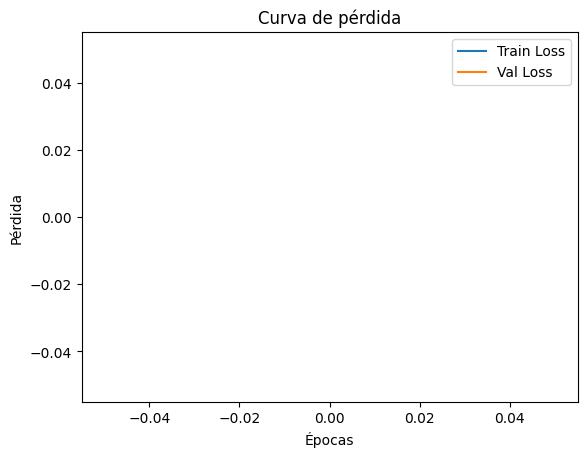

In [49]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.show()

In [33]:
#Instanciar el modelo
model2 = MLP(hidden_size=10, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Convertir el DataFrame a tensores de PyTorch
X_train = torch.tensor(train_df.drop(columns=['Popularity']).values, dtype=torch.float32)  
y_train = torch.tensor(train_df['Popularity'].values, dtype=torch.float32).view(-1, 1)  # Asegurarse de que y tenga la forma correcta


X_val = torch.tensor(val_df.drop(columns=['Popularity']).values, dtype=torch.float32)
y_val = torch.tensor(val_df['Popularity'].values, dtype=torch.float32).view(-1, 1)


X_test = torch.tensor(test_df.drop(columns=['Popularity']).values, dtype=torch.float32)
y_test = torch.tensor(test_df['Popularity'].values, dtype=torch.float32).view(-1, 1)

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)  # Adam optimizer

In [34]:
#Loop de entrenamiento
epochs = 5  # Número de épocas para el entrenamiento
epoch = 0

batch_size = 8.578
batchs_per_epoch = 45

train_losses = []
val_losses = []

while epoch < epochs:    
    model2.train()

    
    input, labels = X_train, y_train  # Obtener un batch de datos
    input, labels = input.to(device), labels.to(device)

    optimizer.zero_grad()

    # 🔧 Salidas 
    output= model2(input)

    # 🔧 Pérdida combinada
    train_loss = criterion(output, labels)

    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss)

    # Validación
    model2.eval()

    with torch.no_grad():
        
        input, labels = X_train, y_train
        input, labels = input.to(device), labels.to(device)

        # 🔧 Solo predicción principal en validación
        outputs = model2(input)  # return_aux=False por defecto
        val_loss = criterion(outputs, labels)

        preds = torch.sigmoid(outputs).cpu().numpy()

    val_losses.append(val_loss)
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    epoch += 1

Época 1 | Train Loss: 1388.8176 | Val Loss: 1386.5251
Época 2 | Train Loss: 1386.5251 | Val Loss: 1383.2905
Época 3 | Train Loss: 1383.2905 | Val Loss: 1379.0564
Época 4 | Train Loss: 1379.0564 | Val Loss: 1374.4260
Época 5 | Train Loss: 1374.4260 | Val Loss: 1370.4170


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

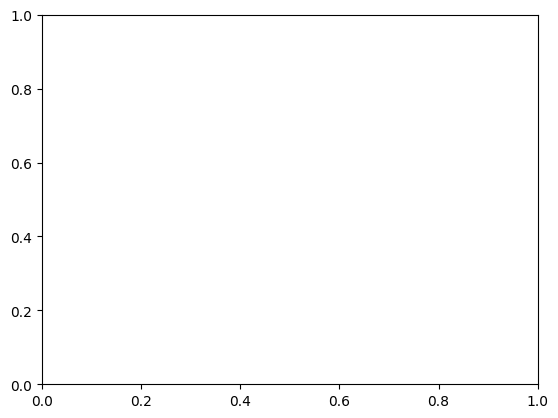

In [35]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.show()